In [41]:
#random.seed(123)
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

true_beta = stats.norm.rvs(loc=0,scale=1,size=1)
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = stats.norm.rvs(loc=0,scale=1,size=100)
y=np.random.normal(x*true_beta, np.sqrt(1/true_phi))

beta0 = stats.norm.rvs(loc=0,scale=1,size=1)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0

print(true_beta,true_phi)
print(theta0)

[-0.1875705] [ 1.33141154]
[-0.19178933  1.82106995]


In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
def FindReasonableEpsilon(theta):
    eps = 1
    r = stats.norm.rvs(size=2)
    theta_prime,r_prime = leapfrog(theta,r,eps)
    if(np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))/np.exp(log_joint(y,x,theta)-(1/2)*r.dot(r))>0.5):
        a = 2-1
    else:
        a = 0-1
    while(np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))/np.exp(log_joint(y,x,theta)-(1/2)*r.dot(r))>pow(2,-a)):
        eps = eps*pow(2,a)
        theta_prime,r_prime = leapfrog(theta,r,eps)
    return eps    

In [44]:
def leapfrog(theta, r, eps):
    n = y.shape[0]
    gradients = np.array(theta[1]*(sum(x*y)-theta[0]*sum(x*x))-theta[0],((.5*n+a-1)/theta[1])-b-.5*sum((y-x*theta[0])*(y-x*theta[0])))
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

In [45]:
def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=theta[0]*x, scale=1/np.sqrt(theta[1])))+norm.logpdf(theta[0],loc=0,scale=1/np.sqrt(1)) +gamma.logpdf(theta[1], a, scale=1/b)
    

In [46]:
def BuildTree(theta, r, u, v, j, eps, theta_0, r_0):
    triangle_max = 1000 #recommend value pg 1359
    if(j==0):
        #base case, take one leapfrog step in direction v
        theta_prime,r_prime = leapfrog(theta,r,v*eps)
        if(u <= np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime))):
            n_prime = 1
        else:
            n_prime = 0
        if(u < np.exp(triangle_max+log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime)) ):
            s_prime = 1
        else:
            s_prime = 0
        return theta_prime,r_prime,theta_prime,r_prime,theta_prime,n_prime,s_prime,min(1,np.exp(log_joint(y,x,theta_prime)-(1/2)*r_prime.dot(r_prime)-
                                                                                               log_joint(y,x,theta_0)+(1/2)*r_0.dot(r_0))),1    
    else:
        #recursion-build the left and right subtrees
        theta_minus,r_minus,theta_plus,r_plus,theta_prime,n_prime,s_prime,alpha_prime,n_aprime = BuildTree(theta,r,u,v,j-1,eps,theta_0,r_0)
        if(s_prime==1):
            if(v == -1):
                theta_minus,r_minus,dash1,dash2,theta_primep,n_primep,s_primep,alpha_primep,n_aprimep = BuildTree(theta_minus,r_minus,u,v,j-1,eps,theta_0,r_0)
            else:
                dash1,dash2,theta_plus,r_plus,theta_primep,n_primep,s_primep,alpha_primep,n_aprimep = BuildTree(theta_plus,r_plus,u,v,j-1,eps,theta_0,r_0)
            if(n_prime+n_primep==0):
                #print('Ahhhh cant divide by zero:',n_prime,n_primep)
                p=.9
            else:    
                p = n_primep/(n_prime+n_primep)
            unif = np.random.uniform()
            if(p>u):
                theta_prime = theta_primep
            alpha_prime = alpha_prime+alpha_primep
            n_aprime = n_aprime+n_aprimep
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):  
                s_prime = s_primep  
            else:
                s_prime = 0  
            n_prime = n_prime+n_primep
    return theta_minus, r_minus, theta_plus, r_plus, theta_prime, n_prime, s_prime, alpha_prime, n_aprime

In [47]:
def hamilt_mc(theta0,delta,y,x, M,M_adapt):
    accept_b = 0
    accept_p = 0
    theta_m = np.zeros((M,2))
    theta_m[0,:] = theta0
    eps = np.zeros((M,1))
    eps[0] = FindReasonableEpsilon(theta_m[0,:])
    mu = np.log(10*eps[0])
    eps_bar = np.zeros((M,1))
    eps_bar[0] = 1
    H_bar = np.zeros((M,1))
    H_bar[0] = 0
    gamma = 0.05
    t0 = 10
    kappa = 0.75
    for m in range(1,M):
        #print('M: ',m,' Theta: ',theta_m[m-1,:])
        r0 = stats.norm.rvs(size=2)
        u = np.random.uniform(low=0,high=np.exp(log_joint(y,x,theta_m[m-1,:])-(1/2)*r0.dot(r0)))
        theta_minus = theta_m[m-1,:]
        theta_plus = theta_m[m-1,:]
        r_minus = r0
        r_plus = r0
        j=0
        theta_m[m,:] = theta_m[m-1,:]
        n = 1
        s = 1
        while(s==1):
            v_j = np.random.choice([-1,1])
            if(v_j==-1):
                theta_minus,r_minus,dash1,dash2,theta_prime,n_prime,s_prime,alpha,n_alpha = BuildTree(theta_minus,r_minus,u,v_j,j,eps[m-1],theta_m[m-1],r0)
            else:
                dash1,dash2,theta_plus,r_plus,theta_prime,n_prime,s_prime,alpha,n_alpha = BuildTree(theta_plus,r_plus,u,v_j,j,eps[m-1],theta_m[m-1],r0)
            if(s_prime == 1):
                p = min(1,n_prime/n)
                unif = np.random.uniform()
                if(p>u):
                    theta_m[m,:] = theta_prime
            n = n+n_prime
            if((theta_plus-theta_minus).dot(r_minus) >= 0 and (theta_plus-theta_minus).dot(r_plus) >= 0):
                s = s_prime
            else:
                s = 0
                accept_b +=1
                accept_p +=1
            j = j+1    
        if(m <= M_adapt):
            H_bar[m] = (1-1/(m+t0))*H_bar[m-1]+1/(m+t0)*(delta-alpha/n_alpha)
            eps[m] = np.exp(mu-(pow(mu,0.5)/gamma)*H_bar[m])
            eps_bar[m] = np.exp(pow(m,-kappa)*np.log(eps[m])+(1-pow(m,-kappa))*np.log(eps_bar[m-1]))
        else:
            eps[m] = eps_bar[M_adapt]
    return(theta_m,accept_b,accept_p)

In [48]:
M = 50000
delta=0.6  #between 0 and 1
M_adapt = 3

In [49]:
%%time
results,acc_b,acc_p = hamilt_mc(theta0, delta,y,x,M,M_adapt)
print("truth", (true_beta, true_phi))
beta_found = np.mean(results[round(4*M/5):(M-1),0])
phi_found = np.mean(results[round(4*M/5):(M-1),1])
print("Mean after burn in we find",beta_found ,phi_found)
print("acceptance (beta then phi)", acc_b/M, acc_p/M)

truth (array([-0.1875705]), array([ 1.33141154]))
Mean after burn in we find -0.191789328101 1.821069948
acceptance (beta then phi) 0.65736 0.65736
CPU times: user 2min 11s, sys: 477 ms, total: 2min 11s
Wall time: 2min 12s


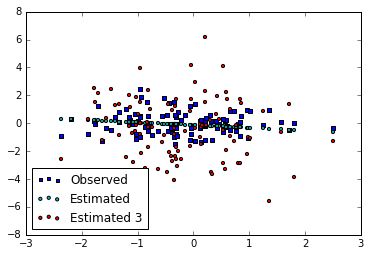

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

y_sim = stats.norm.rvs(loc=x*beta_found,scale=1/np.sqrt(phi_found))
#y_sim2 = stats.norm.rvs(loc=x*beta_found,scale=phi_found)
y_sim3 = np.random.normal(x*beta_found,phi_found)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='Observed')
ax1.scatter(x, y_sim, s=10, c='c', marker="o", label='Estimated')
#ax1.scatter(x, y_sim2, s=10, c='y', marker="o", label='Estimated 2')
ax1.scatter(x, y_sim3, s=10, c='r', marker="o", label='Estimated 3')
plt.legend(loc='lower left');
plt.show()


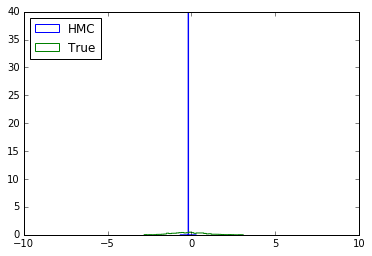

In [55]:


betas = stats.norm.rvs(true_beta,1, size=1000)
phis = stats.gamma.rvs(a=3,scale=1/2,size=1000)

plt.hist(results[round(4*M/5):(M-1),0], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(betas, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([-10,10]);
plt.legend(loc='upper left')
pass

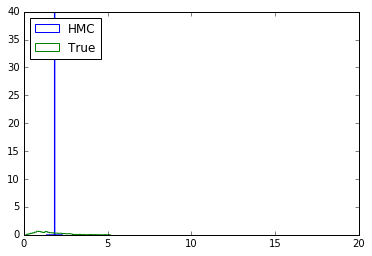

In [56]:
plt.hist(results[round(4*M/5):(M-1),1], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(phis, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,20]);
plt.legend(loc='upper left')
pass

0.69314718055994529

0.64469960642197988